<a href="https://colab.research.google.com/github/AadeshVarude/Structure-from-Motion-and-NERF/blob/main/SFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2 as cv
import scipy
import matplotlib.pyplot as plt
import math
import os
import scipy.optimize
from copy import deepcopy
from google.colab.patches import cv2_imshow
import glob


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import scipy.optimize as optimize
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
import csv

In [ ]:
path='/content/drive/MyDrive/P3Data/P3Data/'

In [ ]:
num_imgs=5
x=np.zeros((1,num_imgs))
x.reshape(-1,num_imgs)

array([[0., 0., 0., 0., 0.]])

**Extract features for the given input data**

In [ ]:
def get_features(path,num_imgs):
  descriptor=[]
  feature_x=[]
  feature_y=[]
  feature_ind=[]
  for n in range(1,num_imgs):
    match_file= path + "matching"+str(n)+".txt"
    file_obj=open(match_file,"r")
    for i,line in enumerate(file_obj):
      if i==0:
        rows=line.split(':')
        nfeat=rows[1]
      else:
        x=np.zeros((1,num_imgs))
        y=np.zeros((1,num_imgs))
        ind=np.zeros((1,num_imgs))


        row=line.split()
        features=[float(x)for x in row]
        features=np.array(features)
        num_match=features[0]
        r=features[1]
        g=features[2]
        b=features[3]
        descriptor.append([r,g,b])

        src_x=features[4]
        src_y=features[5]
        x[0,n-1]=src_x
        y[0,n-1]=src_y
        ind[0,n-1]=1
        m=1
        while num_match >1 :
          img_id=int(features[5+m])
          img_id_x=features[6+m]
          img_id_y=features[7+m]
          m=m+3
          num_match-=1
          x[0,img_id-1]=img_id_x
          y[0,img_id-1]=img_id_y
          ind[0,img_id-1]=1
        feature_x.append(x)
        feature_y.append(y)
        feature_ind.append(ind)

  return np.array(feature_x).reshape(-1,num_imgs), np.array(feature_y).reshape(-1, num_imgs), np.array(feature_ind).reshape(-1, num_imgs), np.array(descriptor).reshape(-1, 3)


In [ ]:
feat_x,feat_y,feat_ind,descriptor=get_features(path,num_imgs)


**Functions for estimating the Fundamental Matrix**

In [ ]:
def normalize(uv):
  uv_ = np.mean(uv, axis=0)
  u_,v_ = uv_[0], uv_[1]
  u_cap, v_cap = uv[:,0] - u_, uv[:,1] - v_

  s = (2/np.mean(u_cap**2 + v_cap**2))**(0.5)
  T_scale = np.diag([s,s,1])
  T_trans = np.array([[1,0,-u_],[0,1,-v_],[0,0,1]])
  T = T_scale.dot(T_trans)

  x_ = np.column_stack((uv, np.ones(len(uv))))
  x_norm = (T.dot(x_.T)).T

  return  x_norm, T

def EstimateFundamentalMatrix(pts1, pts2):
  normalised = True

  x1,x2 = pts1, pts2

  if x1.shape[0] > 7:
    if normalised == True:
      x1_norm, T1 = normalize(x1)
      x2_norm, T2 = normalize(x2)
    else:
      x1_norm,x2_norm = x1,x2

    A = np.zeros((len(x1_norm),9))
    for i in range(0, len(x1_norm)):
      x_1,y_1 = x1_norm[i][0], x1_norm[i][1]
      x_2,y_2 = x2_norm[i][0], x2_norm[i][1]
      A[i] = np.array([x_1*x_2, x_2*y_1, x_2, y_2*x_1, y_2*y_1, y_2, x_1, y_1, 1])

    U, S, VT = np.linalg.svd(A, full_matrices=True)
    F = VT.T[:, -1]
    F = F.reshape(3,3)

    u, s, vt = np.linalg.svd(F)
    s = np.diag(s)
    s[2,2] = 0
    F = np.dot(u, np.dot(s, vt))

    if normalised:
      F = np.dot(T2.T, np.dot(F, T1))
      F = F / F[2,2]
    return F

  else:
    return None

In [ ]:
def errorF(pts1, pts2, F):
  """
  check the epipolar constraint
  """
  x1,x2 = pts1, pts2
  x1tmp=np.array([x1[0], x1[1], 1])
  x2tmp=np.array([x2[0], x2[1], 1]).T

  error = np.dot(x2tmp, np.dot(F, x1tmp))

  return np.abs(error)

In [ ]:
def get_F(pts1,pts2,ind):
  n_iterations = 2000
  error_thresh = 0.002
  inliers_thresh = 0
  chosen_indices = []
  chosen_f = None
  for i in range(0,n_iterations):
    rows=pts1.shape[0]
    rand=np.random.choice(rows,size=8)
    pts1_8=pts1[rand,:]
    pts2_8=pts2[rand,:]
    fund=EstimateFundamentalMatrix(pts1_8,pts2_8)
    indices=[]
    if fund is not None:
      for j in range(rows):
        error = errorF(pts1[j, :], pts2[j, :], fund)
        if error<error_thresh:
          indices.append(ind[j])
    if len(indices)>inliers_thresh:
      inliers_thresh=len(indices)
      selected_ind=indices
      F=fund
  return F,selected_ind

Defining the camera calibration matrix (As the K matrix is provided in data)

In [ ]:
K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0,0,1]]).reshape(3,3)

Extracting the points


In [ ]:
f_matrix = np.empty(shape=(num_imgs, num_imgs), dtype=object)
filtered_feature_flag = np.zeros_like(feat_ind)
ind=np.where((feat_ind[:,0]==1)&(feat_ind[:,1]==1))
ind
for i in range(0,num_imgs-1):
  for j in range(i+1,num_imgs):
    ind=np.where((feat_ind[:,i]==1)&(feat_ind[:,j]==1))
    pts1 = np.hstack((feat_x[ind, i].reshape((-1, 1)), feat_y[ind, i].reshape((-1, 1))))
    pts2 = np.hstack((feat_x[ind, j].reshape((-1, 1)), feat_y[ind, j].reshape((-1, 1))))
    ind = np.array(ind).reshape(-1)

    if len(ind)>8:
      F,selected_ind=get_F(pts1,pts2,ind)
      print('At image : ',  i,j, '|| Number of inliers: ', len(selected_ind), '/', len(ind) )
      f_matrix[i,j]=F
      filtered_feature_flag[selected_ind, i] = 1
      filtered_feature_flag[selected_ind, j] = 1



At image :  0 1 || Number of inliers:  145 / 672
At image :  0 2 || Number of inliers:  93 / 308
At image :  0 3 || Number of inliers:  85 / 352
At image :  0 4 || Number of inliers:  46 / 206
At image :  1 2 || Number of inliers:  181 / 697
At image :  1 3 || Number of inliers:  187 / 789
At image :  1 4 || Number of inliers:  129 / 405
At image :  2 3 || Number of inliers:  256 / 1662
At image :  2 4 || Number of inliers:  276 / 919
At image :  3 4 || Number of inliers:  381 / 1307


In [ ]:
# function for estimating the essential matrix
def get_E(F,K):
  E=K.T.dot(F).dot(K)
  U,s,V=np.linalg.svd(E)
  s=[1,1,0]
  Enew=np.dot(U,np.dot(np.diag(s),V))
  return Enew


In [ ]:
# extract the camera pose from the essential matrix and register it
def CamPose(E):
  W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
  U,D,V=np.linalg.svd(E)
  C1=C3=U[:,2]
  C2=C4=-1*U[:,2]
  R1=R2=np.dot(U,np.dot(W,V))
  R3=R4=np.dot(U,np.dot(W.T,V))
  Cset=[]
  Rset=[]
  Cset.append(C1)
  Cset.append(C2)
  Cset.append(C3)
  Cset.append(C4)
  Rset.append(R1)
  Rset.append(R2)
  Rset.append(R3)
  Rset.append(R4)

  return Rset,Cset

Note check for the determinant of the rotation matrix it should be positive one

In [ ]:
# Testing for two images
m=0
n=1
F12=f_matrix[m,n]
E12=get_E(F12,K)
Rset,Cset=CamPose(E12)


In [ ]:
np.linalg.det(Rset[0]) # the determinant of the rotation matrix has to be 1 as per the right hand thumb rule if not then enforce that constraint

-1.0

**Perform triagulation in order to obtain the X 3D point in the environment**

In [ ]:
def Lin_triangualtion(K,C1,R1,C2,R2,x1,x2):
  I = np.identity(3)
  C1 = np.reshape(C1, (3, 1))
  C2 = np.reshape(C2, (3, 1))
  P1= np.dot(K, np.dot(R1, np.hstack((I, -C1))))
  P2= np.dot(K, np.dot(R2, np.hstack((I, -C2))))
  p1T = P1[0,:].reshape(1,4)
  p2T = P1[1,:].reshape(1,4)
  p3T = P1[2,:].reshape(1,4)

  p1T_ = P2[0,:].reshape(1,4)
  p2T_ = P2[1,:].reshape(1,4)
  p3T_ = P2[2,:].reshape(1,4)

  X=[]
  print(x1.shape[0])
  for i in range(x1.shape[0]):
    x=x1[i,0]
    y=x1[i,1]
    x_=x2[i,0]
    y_=x2[i,1]
    A = []
    A.append((y * p3T) -  p2T)
    A.append(p1T -  (x * p3T))
    A.append((y_ * p3T_) -  p2T_)
    A.append(p1T_ -  (x_ * p3T_))

    A = np.array(A).reshape(4,4)

    _, _, vt = np.linalg.svd(A)
    v = vt.T
    x = v[:,-1]
    X.append(x)
  return np.array(X)

In [ ]:
ind=np.where((filtered_feature_flag[:,m]==1)&(filtered_feature_flag[:,n]==1))
pts1 = np.hstack((feat_x[ind, m].reshape((-1, 1)), feat_y[ind, m].reshape((-1, 1))))
pts2 = np.hstack((feat_x[ind, n].reshape((-1, 1)), feat_y[ind, n].reshape((-1, 1))))


In [ ]:
def makeImageSizeSame(imgs):
  images = imgs.copy()
  sizes = []
  for image in images:
    x, y, ch = image.shape
    sizes.append([x, y, ch])

  sizes = np.array(sizes)
  x_target, y_target, _ = np.max(sizes, axis = 0)

  images_resized = []

  for i, image in enumerate(images):
    image_resized = np.zeros((x_target, y_target, sizes[i, 2]), np.uint8)
    image_resized[0:sizes[i, 0], 0:sizes[i, 1], 0:sizes[i, 2]] = image
    images_resized.append(image_resized)

  return images_resized
def showMatches(image_1, image_2, pts1, pts2, color):
  image_1, image_2 = makeImageSizeSame([image_1, image_2])
  concat = np.concatenate((image_1, image_2), axis = 1)

  if pts1 is not None:
    corners_1_x = pts1[:,0].copy().astype(int)
    corners_1_y = pts1[:,1].copy().astype(int)
    corners_2_x = pts2[:,0].copy().astype(int)
    corners_2_y = pts2[:,1].copy().astype(int)
    corners_2_x += image_1.shape[1]

    for i in range(corners_1_x.shape[0]):
      cv.line(concat, (corners_1_x[i], corners_1_y[i]), (corners_2_x[i] ,corners_2_y[i]), color, 1)
  plt.imshow(concat)


Testin the matches for two images


In [ ]:
image_1=cv.imread(path + '1.png')
image_2=cv.imread(path + '2.png')

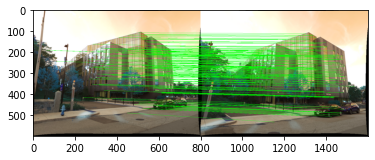

In [ ]:
showMatches(image_1, image_2, pts1, pts2, [0,255,0])

In [ ]:
R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
pts3D_4 = []

for i in range(len(Cset)):
  pts3D = []
  x1 = pts1
  x2 = pts2
  X = Lin_triangualtion(K, C1_, R1_, Cset[i], Rset[i], x1, x2)
  Y=X
  X = X/X[:,3].reshape(-1,1)
  pts3D_4.append(X)

192
192
192
192


In [ ]:
# check the chirality and the depth conditions
def check_chirality(X,R,C):
  r3=R[2,:]
  C=C.reshape(-1,1)
  count=0
  for x3d in X:
    x3d = x3d[0:3].reshape(-1,1)
    if(np.dot(r3,x3d-C)) > 0 and x3d[2]>0 :
      count+=1

  return count

In [ ]:
counts=[]
for i in range(len(Cset)):
  count=check_chirality(pts3D_4[i],Rset[i],Cset[i])
  counts.append(count)
chosen=np.argmax(counts)
chosen


2

In [ ]:
X=pts3D_4[chosen]
print(X[0])
X = X/X[:,3].reshape(-1,1)


[-2.07527385 -1.080586    2.05455462  1.        ]


In [ ]:
R_chosen,C_chosen=Rset[chosen],Cset[chosen]
C_chosen

array([ 0.64743868, -0.03756159,  0.76119135])

**Defining the projection matrix**

In [ ]:
def ProjectionMatrix(R,C,K):
  C = np.reshape(C, (3, 1))
  I = np.identity(3)
  P = np.dot(K, np.dot(R, np.hstack((I, -C))))
  return P

In [ ]:
def Loss(X,pts1,pts2,P1,P2):
  p1_1,p1_2,p1_3=P1
  p1_1,p1_2,p1_3= p1_1.reshape(1,-1),p1_2.reshape(1,-1),p1_3.reshape(1,-1)

  p2_1,p2_2,p2_3=P2
  p2_1,p2_2,p2_3= p2_1.reshape(1,-1),p2_2.reshape(1,-1),p2_3.reshape(1,-1)

  u1,v1=pts1[0],pts1[1]
  udash=np.divide(p1_1.dot(X) , p1_3.dot(X))
  vdash=np.divide(p1_2.dot(X) , p1_3.dot(X))
  E1= np.square(v1 - vdash) + np.square(u1 - udash)

  u2,v2=pts2[0],pts2[1]
  u2dash=np.divide(p2_1.dot(X) , p2_3.dot(X))
  v2dash=np.divide(p2_2.dot(X) , p2_3.dot(X))
  E2= np.square(v2 - v2dash) + np.square(u2 - u2dash)

  eroor=E1+E2
  return eroor.squeeze()


In [ ]:
# this rectifies the geometric error
def NonLinearTrian(K, pts1, pts2, x3D, R1, C1, R2, C2):
  greatX=[]
  P1=ProjectionMatrix(R1,C1,K)
  P2=ProjectionMatrix(R2,C2,K)
  for i in range(len(x3D)):
    optiz = optimize.least_squares(fun=Loss, x0=x3D[i], method="trf", args=[pts1[i], pts2[i], P1, P2])
    X=optiz.x
    greatX.append(X)
  return greatX


In [ ]:
greatX=NonLinearTrian(K, pts1, pts2, X, R1_,C1_, R_chosen, C_chosen)

In [ ]:
def ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K ):

    P1 = ProjectionMatrix(R1,C1,K)
    P2 = ProjectionMatrix(R2,C2,K)

    # X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector

    p1_1T, p1_2T, p1_3T = P1 # rows of P1
    p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

    p2_1T, p2_2T, p2_3T = P2 # rows of P2
    p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

    ## reprojection error for reference camera points - j = 1
    u1,v1 = pt1[0], pt1[1]
    u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
    v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
    E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)

    ## reprojection error for second camera points - j = 2
    u2,v2 = pt2[0], pt2[1]
    u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
    v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))

    E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)

    return E1, E2

In [ ]:
def meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K ):
  Error = []
  for pt1, pt2, X in zip(pts1, pts2, x3D):
    e1,e2 = ReprojectionError(X, pt1, pt2, R1, C1, R2, C2, K )
    Error.append(e1+e2)

  return np.mean(Error)

In [ ]:
mean_error1 = meanReprojectionError(X, pts1, pts2, R1_, C1_, R_chosen, C_chosen, K )
mean_error2 = meanReprojectionError(greatX, pts1, pts2, R1_, C1_, R_chosen, C_chosen, K )
print(n+1,m+1, 'Before optimization LT: ', mean_error1, 'After optimization nLT:', mean_error2)

2 1 Before optimization LT:  498.32607502827676 After optimization nLT: 482.7600344003475


In [ ]:
X_all = np.zeros((feat_x.shape[0], 3))
X_all = np.zeros((feat_x.shape[0], 3))
camera_indices = np.zeros((feat_x.shape[0], 1), dtype = int)
X_found = np.zeros((feat_x.shape[0], 1), dtype = int)

X_all[ind] = X[:, :3]
X_found[ind] = 1
camera_indices[ind] = 1

print(np.nonzero(X_found[ind])[0].shape)
X_found[np.where(X_all[:,2] < 0)] = 0
# print(len(idx[0]), '--' ,np.nonzero(X_found[idx])[0].shape)

(192,)


**For the other images no we will use PNP for the others:
This cell is set of functions used for the Perspective n Points**

In [ ]:
def PnP(X_set,x_set,K):
  N=X_set.shape[0]
  X_stacked=np.hstack((X_set, np.ones((X_set.shape[0], 1))))
  x_stacked=np.hstack((x_set, np.ones((x_set.shape[0], 1))))

  K_inv = np.linalg.inv(K)
  x_n = K_inv.dot(x_stacked.T).T

  for i in range(N):
    X=X_stacked[i].reshape((1,4))
    zeros=np.zeros((1,4))
    u,v,_=x_n[i]
    u_cross = np.array([[0, -1, v],
                        [1,  0 , -u],
                        [-v, u, 0]])
    X_tilda = np.vstack((np.hstack((   X, zeros, zeros)),
                        np.hstack((zeros,     X, zeros)),
                        np.hstack((zeros, zeros,     X))))
    a = u_cross.dot(X_tilda)
    if i>0:
      A=np.vstack((A,a))
    else:
      A=a
    _,_,vt=np.linalg.svd(A)
    P=vt[-1].reshape((3,4))
    R=P[:,:3]
    u,d,v=np.linalg.svd(R)
    R=u.dot(v)
    C=P[:,3]
    C = - np.linalg.inv(R).dot(C)
    if np.linalg.det(R)<0:
      R=-R
      C=-C
  return R,C

def PnPerr(feat,X_test,R,C,K):
  u,v=feat
  # print("u and v",u,v)
  X_test=np.hstack((X_test.reshape(1,-1), np.ones((X_test.reshape(1,-1).shape[0], 1))))
  X_test=X_test.reshape(-1,1)
  C=C.reshape(-1,1)
  P=ProjectionMatrix(R,C,K)
  p1,p2,p3=P
  u_dash=np.divide(p1.dot(X_test),p3.dot(X_test))
  v_dash=np.divide(p2.dot(X_test),p3.dot(X_test))
  # print("u_dash and v_dash",u_dash,v_dash)
  x_proj = np.hstack((u_dash, v_dash))
  x = np.hstack((u, v))
  e = np.linalg.norm(x - x_proj)
  # e = np.sqrt(np.square(u - u_dash) + np.square(v - v_dash))
  return e


def PnPRANSAC(K,feat_pts,X,num_itr=1000,e_thresh=200):
  inliers_thresh=0
  chose_ind=[]
  chosen_t,chose_R=None,None
  num_rows=X.shape[0]
  for i in range(num_itr):
    rand_ind=np.random.choice(num_rows,size=6)
    X_set,x_set=X[rand_ind],feat_pts[rand_ind]
    R,C=PnP(X_set,x_set,K)
    # print(R)
    ind=[]
    if R is not None:

      for j in range(num_rows):
        feat=feat_pts[j]
        X_test=X[j]
        err=PnPerr(feat,X_test,R,C,K)
        # print(err)
        if err<e_thresh:
          ind.append(j)

    if len(ind)>inliers_thresh:
      inliers_thresh=len(ind)
      R_chosen=R
      C_chosen=C
  return R_chosen,C_chosen


In [ ]:
def reprojectionErrorPnP(x3D, pts, K, R, C):
  P = ProjectionMatrix(R,C,K)

  Error = []
  for X, pt in zip(x3D, pts):
    p_1T, p_2T, p_3T = P# rows of P
    p_1T, p_2T, p_3T = p_1T.reshape(1,-1), p_2T.reshape(1,-1), p_3T.reshape(1,-1)
    X = np.hstack((X.reshape(1,-1), np.ones((X.reshape(1,-1).shape[0], 1)))).reshape(-1,1) # make X it a column of homogenous vector
    ## reprojection error for reference camera points
    u, v = pt[0], pt[1]
    u_proj = np.divide(p_1T.dot(X) , p_3T.dot(X))
    v_proj =  np.divide(p_2T.dot(X) , p_3T.dot(X))

    E = np.square(v - v_proj) + np.square(u - u_proj)

    Error.append(E)

  mean_error = np.mean(np.array(Error).squeeze())
  return mean_error


In [ ]:
from scipy.spatial.transform import Rotation
def getQuaternion(R2):
  Q = Rotation.from_matrix(R2)
  return Q.as_quat()
def getRotation(Q, type_ = 'q'):
  if type_ == 'q':
    R = Rotation.from_quat(Q)
    return R.as_matrix()
  elif type_ == 'e':
    R = Rotation.from_rotvec(Q)
    return R.as_matrix()
def homo(pts):
  return np.hstack((pts, np.ones((pts.shape[0], 1))))

In [ ]:
def NonLinearPnP(K, pts, x3D, R0, C0):
  """
  K : Camera Matrix
  pts1, pts2 : Point Correspondences
  x3D :  initial 3D point
  R2, C2 : relative camera pose - estimated from PnP
  Returns:
      x3D : optimized 3D points
  """
  Q = getQuaternion(R0)
  X0 = [Q[0] ,Q[1],Q[2],Q[3], C0[0], C0[1], C0[2]]

  optimized_params = optimize.least_squares(
      fun = PnPLoss,
      x0=X0,
      method="trf",
      args=[x3D, pts, K])
  X1 = optimized_params.x
  Q = X1[:4]
  C = X1[4:]
  R = getRotation(Q)
  return R, C

def PnPLoss(X0, x3D, pts, K):

  Q, C = X0[:4], X0[4:].reshape(-1,1)
  R = getRotation(Q)
  P = ProjectionMatrix(R,C,K)

  Error = []
  for X, pt in zip(x3D, pts):
    p_1T, p_2T, p_3T = P# rows of P
    p_1T, p_2T, p_3T = p_1T.reshape(1,-1), p_2T.reshape(1,-1), p_3T.reshape(1,-1)


    X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
    ## reprojection error for reference camera points
    u, v = pt[0], pt[1]
    u_proj = np.divide(p_1T.dot(X) , p_3T.dot(X))
    v_proj =  np.divide(p_2T.dot(X) , p_3T.dot(X))

    E = np.square(v - v_proj) + np.square(u - u_proj)

    Error.append(E)

  sumError = np.mean(np.array(Error).squeeze())
  return sumError

In [ ]:
C_set_ = []
R_set_ = []
C0 = np.zeros(3)
R0 = np.identity(3)
C_set_.append(C0)
R_set_.append(R0)
C_set_.append(C_chosen)
R_set_.append(R_chosen)


In [ ]:
# Adding the rest of the images
for i in range(2,5):
  feat_ind_i=np.where((X_found[:,0]==1) & (filtered_feature_flag[:,i]==1))
  pts_i = np.hstack((feat_x[feat_ind_i, i].reshape(-1,1), feat_y[feat_ind_i, i].reshape(-1,1)))
  X=X_all[feat_ind_i,:].reshape(-1,3)

  R_int,C_int=PnPRANSAC(K,pts_i,X,num_itr=1000,e_thresh=10)
  errLinearPnP = reprojectionErrorPnP(X, pts_i, K, R_int, C_int)
  print(errLinearPnP)
  Ri, Ci = NonLinearPnP(K, pts_i, X, R_int, C_int)
  errNonLinearPnP = reprojectionErrorPnP(X, pts_i, K, Ri, Ci)
  print(errNonLinearPnP)
  print("appending in the r set")
  R_set_.append(Ri)
  C_set_.append(Ci)
  for j in range(0,i):
    idx_X_pts = np.where((filtered_feature_flag[:, j]==1) & (filtered_feature_flag[:, i]==1))
    if (len(idx_X_pts[0]) < 8):
      continue

    x1 = np.hstack((feat_x[idx_X_pts, j].reshape((-1, 1)), feat_y[idx_X_pts, j].reshape((-1, 1))))
    x2 = np.hstack((feat_x[idx_X_pts, i].reshape((-1, 1)), feat_y[idx_X_pts, i].reshape((-1, 1))))

    X = Lin_triangualtion(K, C_set_[j], R_set_[j], Ci, Ri, x1, x2)
    X = X/X[:,3].reshape(-1,1)

    LT_error = meanReprojectionError(X, x1, x2, R_set_[j], C_set_[j], Ri, Ci, K)

    X = NonLinearTrian(K, x1, x2, X, R_set_[j], C_set_[j], Ri, Ci)
    X=np.array(X)
    X = X/X[:,3].reshape(-1,1)

    nLT_error = meanReprojectionError(X, x1, x2, R_set_[j], C_set_[j], Ri, Ci, K)
    print("Error after linear triangulation: ", LT_error, " Error after non linear triangulation: ", nLT_error)


    X_all[idx_X_pts] = X[:,:3]
    X_found[idx_X_pts] = 1


In [ ]:
def getEuler(R2):
  euler = Rotation.from_matrix(R2)
  return euler.as_rotvec()


**Final Results**

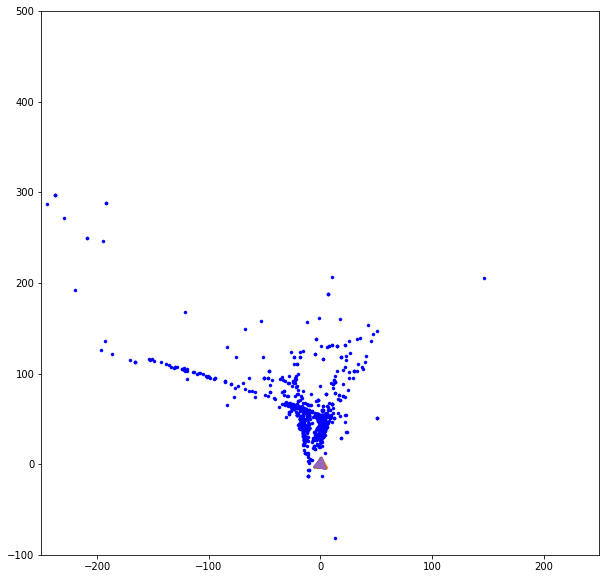

In [ ]:
feature_idx = np.where(X_found[:, 0])
X = X_all[feature_idx]
x = X[:,0]
y = X[:,1]
z = X[:,2]

# 2D plotting
fig = plt.figure(figsize = (10, 10))
plt.xlim(-250,  250)
plt.ylim(-100,  500)
plt.scatter(200*x, 100*z, marker='.',linewidths=0.5, color = 'blue')
for i in range(0, len(C_set_)):
  R1 = getEuler(R_set_[i])
  R1 = np.rad2deg(R1)
  plt.plot(C_set_[i][0],C_set_[i][2], marker=(3, 0, int(R1[1])), markersize=15, linestyle='None')


plt.show()
